## 1. Data Preparation

In [1]:
# Import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# from google_play_scraper import Sort, reviews_all

### 1.1 Data Collection
Note: Dataset provided in this repository was collected on 6-June-2022

- Library used : [google-play-scraper 1.1.0](https://pypi.org/project/google-play-scraper/)
- App Source : [Amazon Shopping - Apps on Google Play](https://play.google.com/store/apps/details?id=com.amazon.mShop.android.shopping)

In [2]:
# Scraping amazon reviews from play store
# amazon_reviews = reviews(
#     "com.amazon.mShop.android.shopping",
#     lang="en",
#     country="us",
#     sort=Sort.NEWEST
# )

# Create dataset from scraped reviews
# reviews = pd.DataFrame(np.array(amazon_reviews), columns=["review"])
# df_reviews = df_reviews.join(pd.DataFrame(reviews.pop("review").tolist()))

In [3]:
df_reviews = pd.read_csv("datasets/reviews_raw.csv")
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              2234 non-null   object 
 1   userName              2234 non-null   object 
 2   userImage             2234 non-null   object 
 3   content               2234 non-null   object 
 4   score                 2234 non-null   int64  
 5   thumbsUpCount         2234 non-null   int64  
 6   reviewCreatedVersion  2200 non-null   object 
 7   at                    2234 non-null   object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
dtypes: float64(2), int64(2), object(6)
memory usage: 174.7+ KB


In [4]:
df_reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,ce0c060d-38a1-4bac-bee1-9555c6f08fdc,Ashley Clark,https://play-lh.googleusercontent.com/a-/AFdZu...,"Generally works great, except every time I ope...",3,2,NaN,2022-06-06 10:27:18,NaN,NaN
1,65c0acfc-4c07-44eb-a467-a6125ca5b437,Omar Sabik,https://play-lh.googleusercontent.com/a/AItbvm...,باد باد لاد,2,0,NaN,2022-06-06 7:42:16,NaN,NaN
2,92914606-9dfd-4512-9b52-4944272fb070,Tamara Shimmel,https://play-lh.googleusercontent.com/a-/AFdZu...,Amazon Prime is absolutely amazing! Great prod...,5,0,24.10.2.100,2022-06-06 7:40:46,NaN,NaN


### 1.2 Data Cleaning

Steps:
- Check for duplicated row
- Check for missing value
- Only keep neccessary column(s)
- Remove newline, special character, and emojis from review
- Remove non-english review (manually)

In [5]:
# Load raw reviews dataset
df_raw = pd.read_csv("datasets/reviews_raw.csv")

In [6]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)
    return re.sub(emoj, "", data)

# Check duplicated row
print(df_raw.duplicated().sum())

# Check missing value
print(df_raw["content"].isna().sum().sum())

# Keep neccessary columns
df_clean = df_raw[["content", "score"]].copy()

# Remove numbers
df_clean["content"].replace(r"\d+","", regex=True, inplace=True)

# Remove emojis
df_clean["content"] = df_clean["content"].apply(remove_emojis)

# Save dataset to csv and tsv file
#df_clean.to_csv("datasets/reviews_clean.csv", index=False)

0
0


In [7]:
df_clean = pd.read_csv("datasets/reviews_clean.csv")
df_clean.head()

,content,score
0,"Generally works great, except every time I ope...",3
1,Amazon Prime is absolutely amazing! Great prod...,5
2,Hello I have change my phone number and since ...,2
3,Outstanding orders? Too difficult to find. Sma...,3
4,"I like it alot, very easy, i love the variety ...",4


### 1.3 Data Labelling (Manually)

Labelling rules: 
- If the review is likely to be negative, the label is negative.
- If the review is likely to be positive, the label is positive.
- If the review tends to be neutral, the label is positive.
- If the review seems ambiguous, the number of positive or negative words determines the sentiment label.
- The rating given by reviewers is also used by researchers as a consideration.

In [8]:
# Import labelled data
df_labelled = pd.read_csv("datasets/reviews_labelled.csv")
df_labelled.head()

,content,score,sentiment
0,"Generally works great, except every time I ope...",3,-1
1,Amazon Prime is absolutely amazing! Great prod...,5,1
2,Hello I have change my phone number and since ...,2,-1
3,Outstanding orders? Too difficult to find. Sma...,3,-1
4,"I like it alot, very easy, i love the variety ...",4,1


In [9]:
# Sentiment distribution
df_labelled["sentiment"].value_counts()

-1    1253
 1     894
Name: sentiment, dtype: int64

In [10]:
# Rating distribution
df_labelled["score"].value_counts(sort=False).sort_index()

1    742
2    269
3    220
4    206
5    710
Name: score, dtype: int64

In [11]:
# Sentiment distribution per rating
df_labelled.groupby("score")["sentiment"].value_counts().sort_index()

score  sentiment
1      -1           742
2      -1           258
        1            11
3      -1           167
        1            53
4      -1            83
        1           123
5      -1             3
        1           707
Name: sentiment, dtype: int64

## 2. Text Preprocessing

Steps:

- Case Folding
- Remove Punctuation
- Remove Stopwords
- Lemmatization

### 2.1. Preparing Resources

In [12]:
# Import libraries
import nltk
import spacy
import string
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as sw_nltk
from nltk.corpus import wordnet
from gensim.parsing.preprocessing import STOPWORDS as sw_gensim

# Download packages
# nltk.download("stopwords") # stopwords
# nltk.download("wordnet") # lemmatization
# nltk.download("omw-1.4") # lemmatization
# nltk.download("averaged_perceptron_tagger") # pos tagging

In [13]:
# Import labelled dataset
df_labelled = pd.read_csv("datasets/reviews_labelled.csv")

# Create temporary dataset
df_temp = pd.DataFrame(df_labelled["content"].copy())
df_temp.head()

,content
0,"Generally works great, except every time I ope..."
1,Amazon Prime is absolutely amazing! Great prod...
2,Hello I have change my phone number and since ...
3,Outstanding orders? Too difficult to find. Sma...
4,"I like it alot, very easy, i love the variety ..."


In [14]:
def show_difference(col1, col2, df=df_temp):
    """Show difference between pre and post processing"""
    pd.set_option('display.max_colwidth', 80)
    # Get modified-only rows
    df_mod = df[df[col1] != df[col2]]
    df_mod = df_mod[df_mod["content"].str.len() < 80]
    # Get 3 random samples
    diff = df_mod.sample(3)[[col1, col2]]
    diff.rename(columns={col1:"before", col2:"after"}, inplace=True)
    
    return diff

### 2.2. Case folding

Converts all review text to lowercase

In [15]:
def case_folding(text):
    return text.lower()

df_temp["lower"] = df_temp["content"].apply(case_folding)
show_difference("content", "lower")

,before,after
1041,"Easy to find items. Easy to navigate options, too. selection is great!!","easy to find items. easy to navigate options, too. selection is great!!"
114,Love Amazon service. Quick delivery. Only setback is cost of shipping.,love amazon service. quick delivery. only setback is cost of shipping.
560,Great service!,great service!


### 2.3. Removing punctuation

List of punctuation from `string.punctuation`:

> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [16]:
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

df_temp["punct"] = df_temp["lower"].apply(remove_punctuation)
show_difference("lower", "punct")

,before,after
1920,"scammers, it a fake app",scammers it a fake app
1999,good always have cool stuff...,good always have cool stuff
1442,convenient and good prices.,convenient and good prices


### 2.4. Removing stopwords

Stopwords used:

- NLTK (179 words)
- Gensim ([337 words](https://tedboy.github.io/nlps/_modules/gensim/parsing/preprocessing.html))
- Spacy ([326 words](https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py))

Total combined = 413 words

In [17]:
# load stopwords
sp = spacy.load('en_core_web_sm')
words_spacy = sp.Defaults.stop_words # spacy
words_nltk = sw_nltk.words("english") # nltk
words_gensim = sw_gensim # gensim

# Stopwords combined
stopwords = words_nltk + list(words_gensim) + list(words_spacy) # 843
# Remove duplicated words
stopwords = sorted(list(set(stopwords)))
# Total stopwords
print(len(stopwords))

412


In [18]:
# Remove Stopwords
def remove_stopwords(text):
    return " ".join([w for w in text.split() if w not in stopwords])

df_temp["stopwords"] = df_temp["punct"].apply(remove_stopwords)
show_difference("punct", "stopwords")

,before,after
677,quick and easy,quick easy
1741,more organized than the website on pc very easy to use and streamlined app,organized website pc easy use streamlined app
285,easy provides convenience and a variety of options on what youre looking for,easy provides convenience variety options youre looking


### 2.5. Lemmatization

In [19]:
# lemmatization with pos tags help
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize(pos_tags):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(pos_tags))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

lemmatizer = WordNetLemmatizer()
df_temp["lemmatize"] = df_temp["stopwords"].apply(lemmatize)
show_difference("stopwords", "lemmatize")

,before,after
2007,scams fraud sellers app beware,scam fraud seller app beware
285,easy provides convenience variety options youre looking,easy provide convenience variety option youre look
131,best shopping app works super smooth easy use love,best shopping app work super smooth easy use love


## 2.5 Word Clouds

Library used: [wordcloud 1.8.2.2](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html)

Documentation: [wordcloud.WordCloud](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html)

Labels:
- (A) Wordcloud for all classes
- (B) Wordcloud for positive class
- (C) Wordcloud for negative class


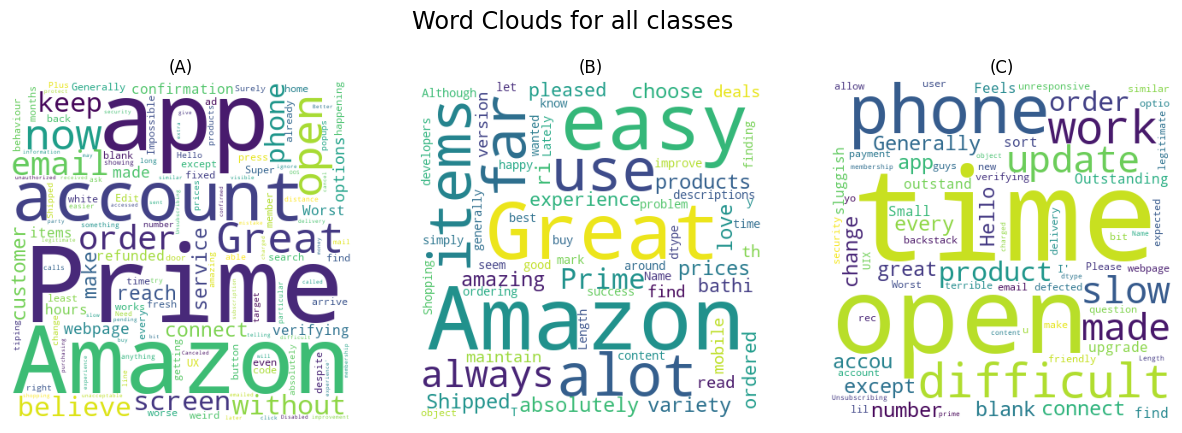

In [20]:
# get texts for wordcloud
wordcloud_all = df_labelled["content"].values
wordcloud_pos = df_labelled[df_labelled["sentiment"] == 1]["content"]
wordcloud_neg = df_labelled[df_labelled["sentiment"] == -1]["content"]

# visualize wordclouds
cloud_content = {"A":wordcloud_all, "B":wordcloud_pos, "C":wordcloud_neg} 
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Word Clouds for all classes", fontsize="xx-large");
for i,(key, text) in enumerate(cloud_content.items()):
    wordcloud = WordCloud(background_color="white", 
                          height=400).generate(str(text))
    ax[i].imshow(wordcloud);
    ax[i].axis("off");
    ax[i].title.set_text(f"({key})")

In [21]:
# Save postprocess text to new dataframe
df_post = pd.DataFrame()
df_post["content"] = df_temp["lemmatize"]
df_post["sentiment"] = df_labelled["sentiment"]
df_post.to_csv("datasets/reviews_post-processing.csv", index=False)
df_post.head()

,content,sentiment
0,generally work great time open app open blank white screen press button arri...,-1
1,amazon prime absolutely amaze great product great price ship right door,1
2,hello change phone number connect tomy account plus tip particular apps show...,-1
3,outstanding order difficult small upgrade sort outstanding order update mark...,-1
4,like alot easy love variety item choose,1


# 3. Sentiment Analysis



In [22]:
import warnings
warnings.filterwarnings('ignore')
# pd.set_option("display.float_format", lambda x: "%.02f" % x)

In [23]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

## 3.1 Compiling Models

Import naive bayes precompiled classes from sklearn

Documentation: https://scikit-learn.org/stable/modules/naive_bayes.html

In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# specify the classifiers
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Gaussian NB": GaussianNB(),
    "Multinominal NB": MultinomialNB()
}

## 3.2 Perform Sentiment Classification

In [25]:
def sentiment_analysis(classifier, data_split):
    """Perform sentiment analysis"""
    X_train, X_test, Y_train, Y_test = data_split
    # fitting model
    classifier.fit(X_train.todense(), Y_train)
    # perform prediction
    predicted = classifier.predict(X_test.todense())
    
    # accuracy
    accuracy = accuracy_score(Y_test, predicted)
    # precision, recall, f-measure and support for each class
    scores = list(precision_recall_fscore_support(Y_test, predicted, average='binary')[:-1])
    # confusion matrix
    cf_matrix = confusion_matrix(Y_test, predicted)

    return [[accuracy]+scores, cf_matrix]

In [26]:
# Load review dataset
df_reviews = pd.read_csv("reviews_post-processing.csv")
reviews = df_reviews["content"]
sentiment = df_reviews["sentiment"]

# creating document-term matrix
tfidf = TfidfVectorizer(ngram_range=(1,1)).fit_transform(reviews)

# splitting data 
tfidf_split = train_test_split(tfidf, sentiment, test_size=0.2, random_state=5)

In [27]:
# dictionary for saving classifier performances
performance = {}

# perform sentiment analysis for each classifier and save the result to dict
for i, (key, classifier) in enumerate(classifiers.items()):
    result = sentiment_analysis(classifier, tfidf_split)
    performance[key] = {}
    performance[key]["scores"] = result[0]
    performance[key]["matrix"] = result[1]

# 4. Model Evaluation

## 4.1 Scores

In [28]:
# create dataframe to store scores for each classifiers
df_cols = ["classifier", "accuracy", "precision", "recall", "fscore"]
df_scores = pd.DataFrame(columns=df_cols)
df_scores["classifier"] = classifiers.keys()
df_scores.set_index(["classifier"], inplace=True)

# add scores to dataframe
for i, (key, perf) in enumerate(performance.items()):
    df_scores.iloc[i,:] = perf["scores"]

df_scores

,accuracy,precision,recall,fscore
classifier,,,,
Bernoulli NB,0.865116,0.769231,0.897436,0.828402
Gaussian NB,0.690698,0.558376,0.705128,0.623229
Multinominal NB,0.886047,0.890511,0.782051,0.832765


In [29]:
print(f"Average Accuracy    = {df_scores['accuracy'].mean()* 100:.3f}%")
print(f"Average Precision   = {df_scores['precision'].mean()* 100:.3f}%")
print(f"Average Recall      = {df_scores['recall'].mean()* 100:.3f}%")
print(f"Average F-Score     = {df_scores['fscore'].mean()* 100:.3f}%")

Average Accuracy    = 81.395%
Average Precision   = 73.937%
Average Recall      = 79.487%
Average F-Score     = 76.147%


## 4.2 Confusion Matrix

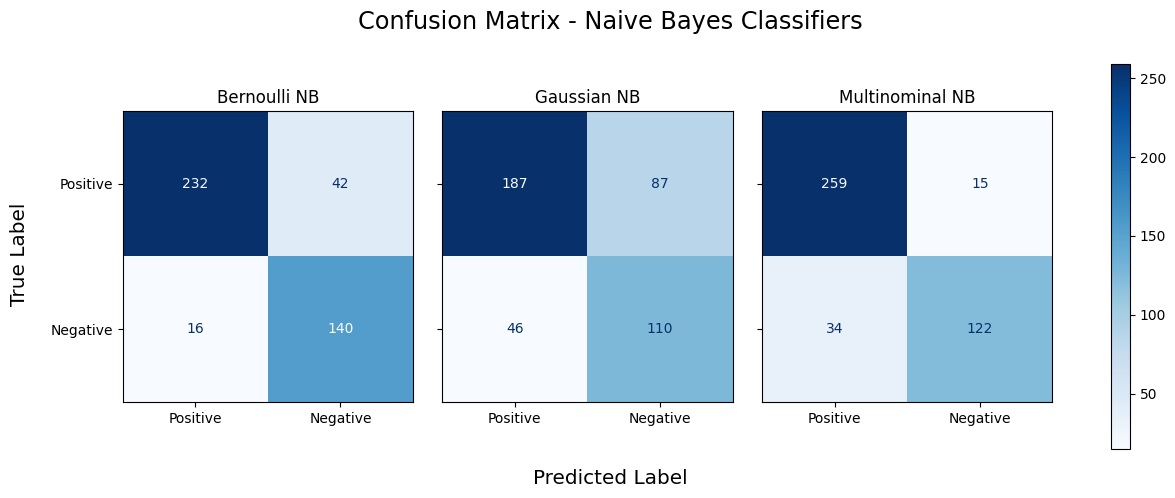

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Positive", "Negative"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey='row')
for i, (key, perf) in enumerate(performance.items()):
    cf_matrix = perf["matrix"]
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
    disp.plot(ax=axes[i], xticks_rotation=0, 
              cmap=plt.cm.Blues, values_format="g", colorbar=False)
    disp.ax_.set_title(key)
    disp.ax_.set_xlabel("")
    disp.ax_.set_ylabel("")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.text(0.45, 0.95, "Confusion Matrix - Naive Bayes Classifiers", ha="center", fontsize="xx-large")
fig.text(0.45, 0.04, "Predicted Label", ha="center", fontsize="x-large")
fig.text(0.05, 0.50, "True Label", va="center", rotation='vertical', fontsize="x-large")
fig.colorbar(disp.im_, ax=axes)
plt.show()

# 5. Trying different classifiers

In [31]:
# import classifiers
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# specify the classifiers
classifiers_2 = {
    "Support Vector": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression()
}

# create dataframe to store performance each classifiers
df_otherclass = pd.DataFrame(columns=df_cols)
df_otherclass["classifier"] = classifiers_2.keys()
df_otherclass.set_index(["classifier"], inplace=True)

# perform sentiment analysis for each classifier
performance_2 = {}
for i, (key, classifier) in enumerate(classifiers_2.items()):
    result = sentiment_analysis(classifier, tfidf_split)
    performance_2[key] = {}
    performance_2[key]["scores"] = result[0]
    performance_2[key]["matrix"] = result[1]

for i, (key, perf) in enumerate(performance_2.items()):
    df_otherclass.iloc[i,:] = perf["scores"]

df_otherclass

,accuracy,precision,recall,fscore
classifier,,,,
Support Vector,0.890698,0.892086,0.794872,0.840678
Decision Tree,0.795349,0.686813,0.801282,0.739645
Random Forest,0.881395,0.830189,0.846154,0.838095
Logistic Regression,0.890698,0.875862,0.814103,0.843854


In [32]:
all = pd.concat([df_scores,df_otherclass])
all.sort_values("accuracy", ascending=False, inplace=True)
all

,accuracy,precision,recall,fscore
classifier,,,,
Support Vector,0.890698,0.892086,0.794872,0.840678
Logistic Regression,0.890698,0.875862,0.814103,0.843854
Multinominal NB,0.886047,0.890511,0.782051,0.832765
Random Forest,0.881395,0.830189,0.846154,0.838095
Bernoulli NB,0.865116,0.769231,0.897436,0.828402
Decision Tree,0.795349,0.686813,0.801282,0.739645
Gaussian NB,0.690698,0.558376,0.705128,0.623229


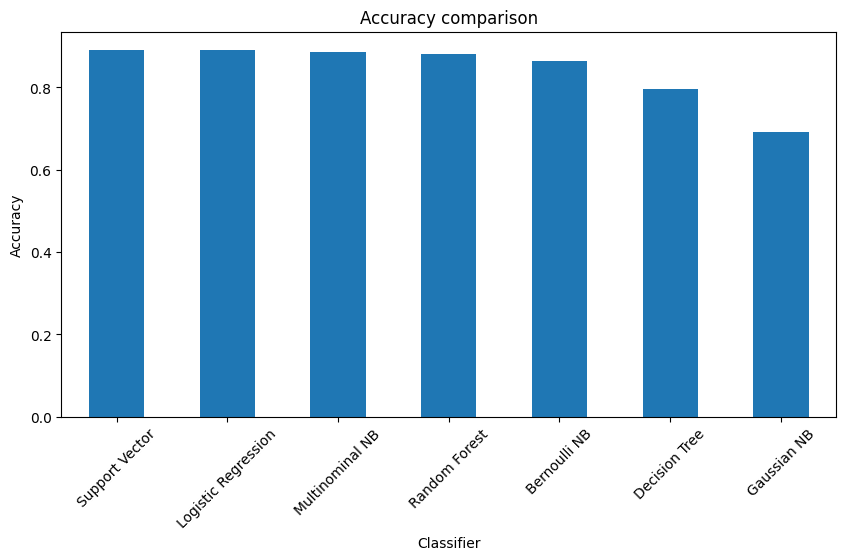

In [33]:
all["accuracy"].plot(kind="bar", rot=45, figsize=(10,5),
                     title="Accuracy comparison",
                     xlabel="Classifier", ylabel="Accuracy"); 